# Bifurcation-Trifurcation dataset (SD 2)

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import scipy
from functools import partial
from os.path import exists
import multiprocess
import scipy.sparse
import matplotlib.pyplot as plt
from p_tqdm import p_map
import seaborn as sns

In [2]:
# load the example dataset, the synthetic data from Arthur's original paper and Sergio's thesis
path = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
syndata = pd.read_csv(path + "/trifbif/trifbif_data.csv",header=0,index_col=0)

## bIFW

### Preprocessing the count matrix:

In [3]:
#### Preprocessing the count matrix: normalisation and binarisation
def bIFW_preprocess_counts(count_matrix, clip = True, cutoff_percentile = 25):
    if clip == True:
        print(f"Clipping the matrix to remove outliers.\n")
        # the clipping from cESFW
        Upper = np.percentile(count_matrix,97.5,axis=0) #get upper percentile of each gene (column)
        #now for those which have 0 as the 97.5th percentile, just get the maximum value as the upper
        Upper[Upper == 0] = np.max(count_matrix,axis=0)[Upper == 0] 
        count_matrix = count_matrix.astype(float)
        count_matrix = count_matrix.clip(upper=Upper,axis=1) #We do this for columns (for clip its 1)
    
    count_max = np.max(count_matrix,axis=0) #get the max, which is 97.5th percentile if clip == True, to normalise
    norm_orig = count_matrix / count_max #just normalise using max value
    if np.where(count_max == 0)[0].shape[0] > 0:
        print(f"There were {np.where(count_max == 0)[0].shape[0]} genes with 0 counts in all cells. Dropping them to prevent NaN formation.\n")
        # drop columns with all 0s
        norm_orig = norm_orig.loc[:, norm_orig.columns[norm_orig.sum() != 0]]
        count_matrix = count_matrix.loc[:, count_matrix.columns[count_matrix.sum() != 0]]
    print(f"Normalisation done. Matrix shape is {norm_orig.shape}. Now discretising.\n")
    
    # now discretisation: for bIFW, it is a two-state discretisation or binarisation
    def two_state_discretisation(feature, cutoff_percentile = cutoff_percentile):
        res = np.zeros(len(feature))
        res[np.where(feature == 0)] = 0
        nonzero = feature[np.where(feature != 0)]
        cutoff = np.percentile(nonzero, cutoff_percentile)
        bins = [cutoff]
        if cutoff >= 0.95: # if the cutoff is too high (i.e., the chosen percentile is close to the maximum value), then we binarise differently
            nonzero_vals = np.ones(len(nonzero))
        else:
            nonzero_vals = np.digitize(nonzero, bins = bins, right = True)
        res[np.where(feature != 0)] = nonzero_vals
        return res.astype(int)
    
    Feature_IDs = norm_orig.columns
    binarised_matrix = []
    for i in range(len(Feature_IDs)):
        binarised_matrix.append(two_state_discretisation(np.array(norm_orig.iloc[:, i])))
        
    print(f"Discretisation done. Returning resulting normalised and binarised matrices.\n")
    binarised_matrix = np.array(binarised_matrix).T
    binarised_df = pd.DataFrame(data=binarised_matrix, columns=Feature_IDs, index=norm_orig.index)
    
    if np.where(count_max == 0)[0].shape[0] > 0:
        return np.where(count_max == 0)[0], count_matrix, norm_orig, binarised_df
    return norm_orig, binarised_df

zerogenes, syndata, norm_orig, binarised_df = bIFW_preprocess_counts(count_matrix=syndata)

Clipping the matrix to remove outliers.

There were 25 genes with 0 counts in all cells. Dropping them to prevent NaN formation.

Normalisation done. Matrix shape is (5000, 4040). Now discretising.

Discretisation done. Returning resulting normalised and binarised matrices.



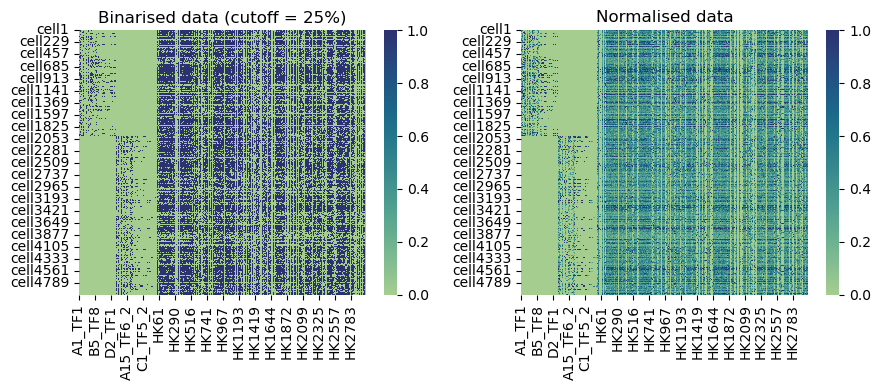

In [4]:
# Visual check to see whether the binarisation is reasonable
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(binarised_df, cmap="crest", ax=axes[0])
axes[0].set_title(f'Binarised data (cutoff = {25}%)')

sns.heatmap(norm_orig, cmap="crest", ax=axes[1])
axes[1].set_title('Normalised data')

plt.tight_layout()
plt.show()

#### Optional: inspect dataframe to make informed preprocessing decisions

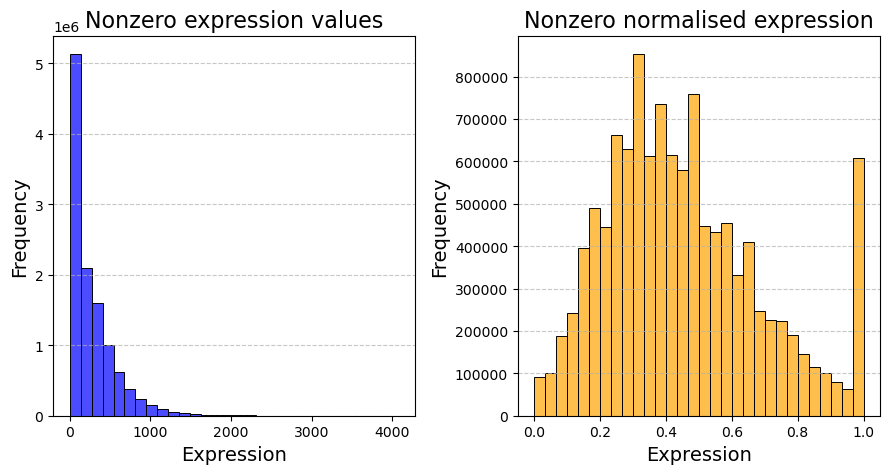

In [5]:
# We can also check the distribution of the nonzero data
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
sns.histplot(syndata[syndata > 0].values.flatten(), bins=30, color='blue', alpha=0.7, ax = axes[0])
axes[0].set_title('Nonzero expression values', fontsize=16)
axes[0].set_xlabel('Expression', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(norm_orig[norm_orig > 0].values.flatten(), bins=30, color='orange', alpha=0.7, ax = axes[1])
axes[1].set_title('Nonzero normalised expression', fontsize=16)
axes[1].set_xlabel('Expression', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

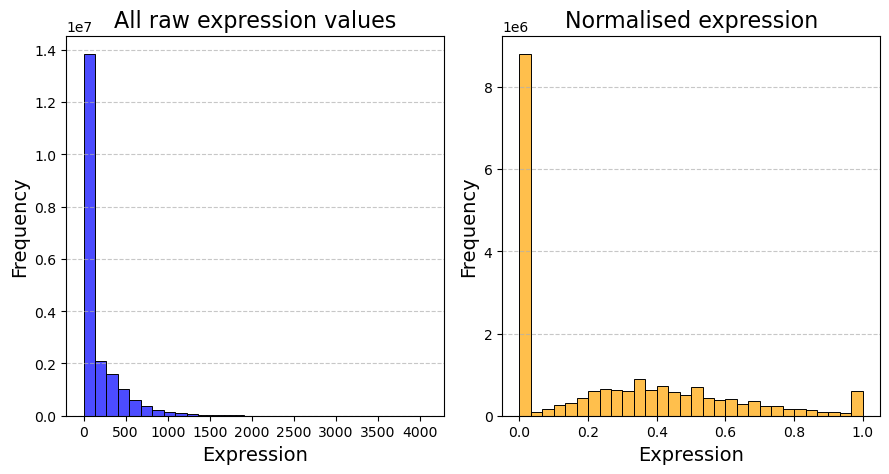

In [6]:
# We can also check the distribution of the nonzero data
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
sns.histplot(syndata.values.flatten(), bins=30, color='blue', alpha=0.7, ax = axes[0])
axes[0].set_title('All raw expression values', fontsize=16)
axes[0].set_xlabel('Expression', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(norm_orig.values.flatten(), bins=30, color='orange', alpha=0.7, ax = axes[1])
axes[1].set_title('Normalised expression', fontsize=16)
axes[1].set_xlabel('Expression', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [7]:
# Ideally, one should use summary statistics...
print(syndata.describe().T)

         count        mean         std   min    25%    50%    75%      max
A1_TF1  5000.0    0.344400    0.722698   0.0    0.0    0.0    0.0    3.000
A1_TF2  5000.0    0.777400    1.309577   0.0    0.0    0.0    1.0    5.000
A1_TF3  5000.0    0.744000    1.231084   0.0    0.0    0.0    1.0    4.000
A1_TF4  5000.0    0.618000    1.080884   0.0    0.0    0.0    1.0    4.000
A1_TF5  5000.0    0.621200    1.091398   0.0    0.0    0.0    1.0    4.000
...        ...         ...         ...   ...    ...    ...    ...      ...
HK2996  5000.0  457.475000  176.233598  90.0  326.0  430.0  564.0  896.000
HK2997  5000.0  261.314225  115.865971  51.0  174.0  243.0  330.0  567.025
HK2998  5000.0    8.934600    4.654874   0.0    5.0    8.0   12.0   21.000
HK2999  5000.0    0.004600    0.083548   0.0    0.0    0.0    0.0    3.000
HK3000  5000.0    0.003400    0.070636   0.0    0.0    0.0    0.0    2.000

[4040 rows x 8 columns]


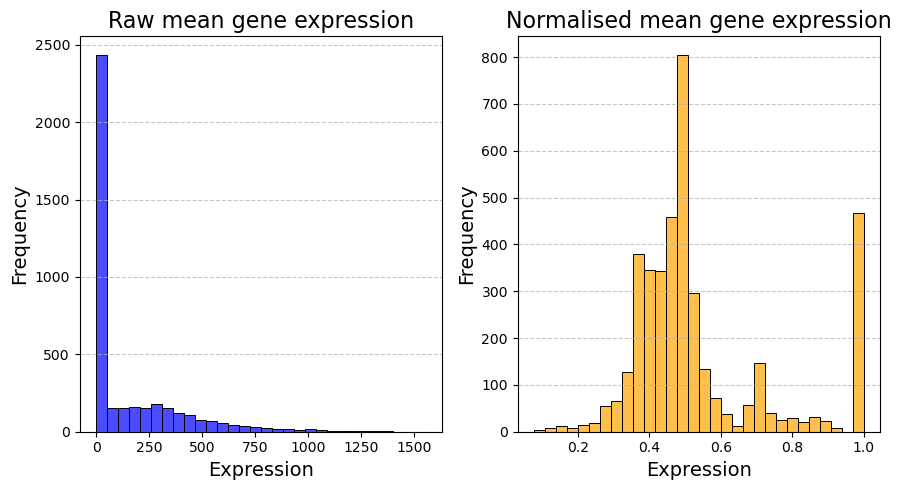

In [8]:
# ... or use metrics to inspect the nonzero distributions
means_raw = syndata[syndata > 0].mean(axis=0)
means_norm = norm_orig[norm_orig > 0].mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
sns.histplot(means_raw, bins=30, color='blue', alpha=0.7, ax = axes[0])
axes[0].set_title('Raw mean gene expression', fontsize=16)
axes[0].set_xlabel('Expression', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(means_norm, bins=30, color='orange', alpha=0.7, ax = axes[1])
axes[1].set_title('Normalised mean gene expression', fontsize=16)
axes[1].set_xlabel('Expression', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Carry out significance testing to assess which pairwise comparisons are worth making

In [9]:
#### Significance testing: the chi-squared test

# Perform test for a single feature using the indices from the upper triangular matrix (triu)
def test_binarised_chisq(feature_ind, triu, binarised_df):
    import numpy as np
    import scipy
    
    triu_ind = [feat[1] for feat in triu if feat[0] == feature_ind][0]
    f1 = np.array(binarised_df.iloc[:,feature_ind])
    chip = []
    chistat = []
    
    for i in triu_ind:
        #define feature 2
        f2 = np.array(binarised_df.iloc[:,i])
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        # get number of counts
        else:
            n00 = 0
            n01 = 0
            n10 = 0
            n11 = 0
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
            allns = [n11, n10, n01, n00]
            n_by_ind = np.array(allns) #.T
            C = binarised_df.shape[0]

            p_11 = ((n11 + n10)/C) * ((n11 + n01)/C)
            p_10 = ((n11 + n10)/C) * (1 - (n11 + n01)/C)
            p_01 = (1 - (n11 + n10)/C) * ((n11 + n01)/C)
            p_00 = (1 - (n11 + n10)/C) * (1 - (n11 + n01)/C)
            probs = [p_11,p_10,p_01,p_00]
            probs_byind = np.array(probs) #.T

            #total = []
            #freq = []

            total = np.sum(n_by_ind) # should just be number of cells
            freq = probs_byind * total

            chip.append(scipy.stats.chisquare(n_by_ind, f_exp=freq).pvalue)
            chistat.append(scipy.stats.chisquare(n_by_ind, f_exp=freq).statistic)
                
    return [chip, chistat]

# Perform the test for all features in parallel
def parallel_chisq(binarised_data, Use_Cores=-1):
    import numpy as np
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient significance testing.\n")
    ## Provide indices for parallel computing and efficiency
    n = binarised_dataset.shape[1]
    def triu_list(n):
        triu_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
        triu = []
        for f in np.unique(triu_indices[0]):
            l = triu_indices[1][triu_indices[0] == f]
            triu.append([f,l])
        return triu, triu_indices
    triu, triu_indices = triu_list(n)
    Feature_Inds = [feat[0] for feat in triu]
    print(f"Indices obtained. Proceeding with performing statistical tests in parallel.\n")
    
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        chisq = p_map(partial(test_binarised_chisq, binarised_df=binarised_dataset, triu=triu), Feature_Inds, num_cpus=Use_Cores)
    chip = [row[0] for row in chisq]
    
    print(f"Calculations complete. Reconstructing significance matrix.\n")
    # Use allscores to build square matrix
    indices = (triu_indices[0], triu_indices[1])
    values = [value for sublist in chip for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value

    print(f"Matrix construction complete. Saving to dataframe.\n")
    m = pd.DataFrame(matrix)
    chip_m = m + m.T - np.diag(np.diag(m)) # make square
    nan_values = np.sum(np.isnan(chip_m.values))
    print(f"There are {nan_values} NaN values in the masked significance matrix ({nan_values/(chip_m.shape[0]*chip_m.shape[0])} %).")
    return chisq, chip_m

chisq, chip = parallel_chisq(binarised_data=binarised_df, Use_Cores=4)

Data loaded. Shape: (5000, 4040). Proceeding to obtain indices for efficient significance testing.

Indices obtained. Proceeding with performing statistical tests in parallel.

Cores Available: 8
Cores Used: 4


  0%|          | 0/4039 [00:00<?, ?it/s]

Calculations complete. Reconstructing significance matrix.

Matrix construction complete. Saving to dataframe.

There are 0 NaN values in the masked significance matrix (0.0 %).


The raw significance matrix is made of p-values or $\Phi$, which will determine which pairwise comparisons to make.

In [10]:
# We then log-transform the significance matrix and mask it for calculating correlations
    # We use a Bonferroni correction for this example
def mask_non_sig(sign_matrix, threshold=0.05, bonferroni=True):
    n = sign_matrix.shape[0]
    np.fill_diagonal(sign_matrix.to_numpy(), 0)
    t_sign_matrix = np.absolute(sign_matrix)
    #avoid log(0) by setting a cutoff
    cutoff = 1e-300
    t_sign_matrix[t_sign_matrix < cutoff] = 0
    t_sign_matrix[t_sign_matrix > cutoff] = -np.log(t_sign_matrix[t_sign_matrix > cutoff])
    if bonferroni == True:
        corrected_thr = -np.log(threshold/(n*n))
        print(f"Bonferroni-corrected -log(p) threshold is {corrected_thr}, and the p-value is {threshold/(n*n)}")
    else:
        corrected_thr = -np.log(threshold)
        print(f"Non-corrected -log(p) threshold is {corrected_thr}, and the p-value is {threshold}")
    tm_sign_matrix = t_sign_matrix.copy()
    tm_sign_matrix[tm_sign_matrix < corrected_thr] = 0
    np.fill_diagonal(tm_sign_matrix.to_numpy(), 0) #remove inf values...
    print(f"The maximum value in the matrix is: {tm_sign_matrix.max().max()} and the minimum value is: {tm_sign_matrix.min().min()}\n")
    nan_values = np.sum(np.isnan(tm_sign_matrix.values))
    print(f"There are {nan_values} NaN values in the masked significance matrix ({nan_values/(tm_sign_matrix.shape[0]*tm_sign_matrix.shape[0])} %).")
    print(f"Returning the transformed significance matrix and the transformed and masked significance matrix.\n")
    return t_sign_matrix, tm_sign_matrix

chip_t, chip_masked = mask_non_sig(sign_matrix=chip, threshold=0.05, bonferroni=True)

Bonferroni-corrected -log(p) threshold is 19.603732215464383, and the p-value is 3.063425154396628e-09
The maximum value in the matrix is: 690.7708795590573 and the minimum value is: 0.0

There are 0 NaN values in the masked significance matrix (0.0 %).
Returning the transformed significance matrix and the transformed and masked significance matrix.



Optional: to assess p-value threshold choice, one can inspect the transformed but unmasked matrix.

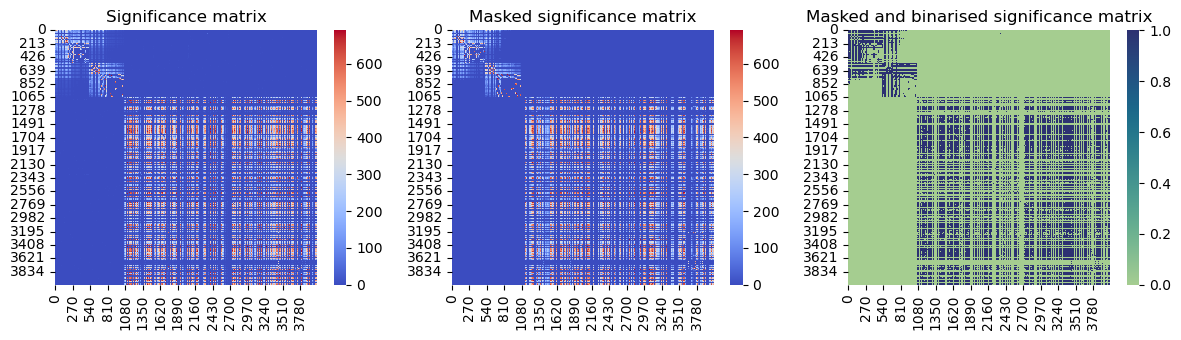

In [97]:
# Heatmap of significance matrix, masked significance matrix and binarised masked significance matrix
chip_masked_bin = np.where(chip_masked > 0, 1, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
sns.heatmap(chip_t, cmap="coolwarm", ax = axes[0])
axes[0].set_title('Significance matrix', fontsize=12)

sns.heatmap(chip_masked, cmap="coolwarm", ax = axes[1])
axes[1].set_title('Masked significance matrix', fontsize=12)

sns.heatmap(chip_masked_bin, cmap="crest", ax = axes[2])
axes[2].set_title('Masked and binarised significance matrix', fontsize=12)

plt.tight_layout()
plt.show()

### Calculate correlation metric Omega ($\Omega$)

In [12]:
#### Omega (Ω), the correlation metric, formerly Entropy Sort Score (ESS)

# The individual function to calculate the Omega score for a given feature
def bIFW_correlation(feature_ind, sign_comp, normalised_matrix, extra_vectors = False, zero_info = True, extra_info = False):
    import numpy as np
    import scipy
    # get the list of significant features
    sign_list = [feat[1] for feat in sign_comp if feat[0] == feature_ind][0]
    MI_vector = []
    S_q_vector = []
    S_m_vector = []
    f1 = np.array(normalised_matrix.iloc[:,feature_ind])
    
    for i in sign_list:
        #define feature 2
        f2 = np.array(normalised_matrix.iloc[:,i])
        n00 = 0
        n01 = 0
        n10 = 0
        n11 = 0
        
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        else:
            c = len(f1)
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
        # check discretization
        ns = np.array([n00, n01, n10, n11])
        n_str = ["n00", "n01", "n10", "n11"]
        nsum = np.sum(ns)
        if nsum != c:
            print("Sum of state counts do not add up.")
            MI = np.nan
            S_q = np.nan
            S_m = np.nan
            
        #calculate c's - need to have at least one of each
        else:
            #wrt to f1
            c_m0 = n00 + n01
            c_m1 = n10 + n11
            #wrt to f2
            c_q0 = n00 + n10
            c_q1 = n01 + n11
            
            cs_MI = np.array([[c_m0, c_q0], [c_m0, c_q1],
                              [c_m1, c_q0], [c_m1, c_q1]])
            cs_S = np.array([[c_m0, c_m1],
                             [c_q0, c_q1]])
            
            MI_terms = []
            zeroterms = []
            for ind, n in enumerate(ns):
                if n != 0 & np.all(cs_MI[ind]) == False: #if n and both cs are nonzero, calculate
                    MI_term = (n/c * np.log2(c * n / (cs_MI[ind][0] * cs_MI[ind][1])))
                    MI_terms.append(MI_term)
                    
                else:
                    zeroterms.append(n_str[ind])
            MI = np.sum(MI_terms)
            
            # entropies separately
            S_m_terms = []
            S_q_terms = []
            
            for ind in range(len(cs_S)):
                S_m_terms.append(cs_S[0][ind]/c * np.log2(cs_S[0][ind]/c))
                S_q_terms.append(cs_S[1][ind]/c * np.log2(cs_S[1][ind]/c))
                
            S_m = np.sum(S_m_terms) * (-1)
            S_q = np.sum(S_q_terms) * (-1)

            if extra_info == True:     
                exclude = str()
                for t in zeroterms:
                    exclude += (t + ", ")
                print("Be aware that the counts " + exclude + "were 0. This affects the calculations.")
                
        MI_vector.append(MI)
        S_q_vector.append(S_q)
        S_m_vector.append(S_m)
    
    max_entropy = [max(Sm, Sq) for Sm, Sq in zip(S_m_vector, S_q_vector)]
    
    #now calculate omega
    if len(MI_vector) != len(max_entropy):
        raise ValueError("All vectors (MI, x_max, S_q and S_m) must have the same length")    

    omega_vector = np.array(MI_vector) / np.array(max_entropy)
    if extra_vectors == True:
        return [omega_vector, MI_vector, max_entropy]            
    else:
        return [omega_vector]
    
    
# The parallelised function to calculate the Omega for all features
def parallel_bIFW_correlation(binarised_data, sign_matrix, Use_Cores=-1):
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient ESS calculation.\n")
    nonzero = np.nonzero(sign_matrix.to_numpy())
    sign_comp = []
    for f in np.unique(nonzero[0]):
        #print(f"Gene {f} has a significant interaction with genes {nonzero[1][nonzero[0] == f]}")
        l = nonzero[1][nonzero[0] == f]
        sign_comp.append([f,l])
        #print(f"Gene {f} has a significant interaction with {len(l)} genes")
    Feature_Inds = [feat[0] for feat in sign_comp]
    print(f"Indices obtained. Proceeding with calculating ESSs in parallel.\n")
    
    ## Identify number of cores to use.
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        allscores = p_map(partial(bIFW_correlation, sign_comp=sign_comp, normalised_matrix=binarised_dataset), Feature_Inds, num_cpus=Use_Cores)
    print(f"Calculations complete. Proceeding with matrix reconstruction.\n")
    omega = [row[0] for row in allscores]
    
    # Use allscores to build square matrix
    n = binarised_dataset.shape[1]
    indices = (nonzero[0], nonzero[1])
    values = [value for sublist in omega for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value
    
    print("Matrix construction complete. Saving to dataframe.")
    m = pd.DataFrame(matrix)
    return allscores, m

allscores, omega_matrix = parallel_bIFW_correlation(binarised_data=binarised_df, sign_matrix=chip_masked, Use_Cores=4)

Data loaded. Shape: (5000, 4040). Proceeding to obtain indices for efficient ESS calculation.

Indices obtained. Proceeding with calculating ESSs in parallel.

Cores Available: 8
Cores Used: 4


  0%|          | 0/3450 [00:00<?, ?it/s]

Calculations complete. Proceeding with matrix reconstruction.

Matrix construction complete. Saving to dataframe.


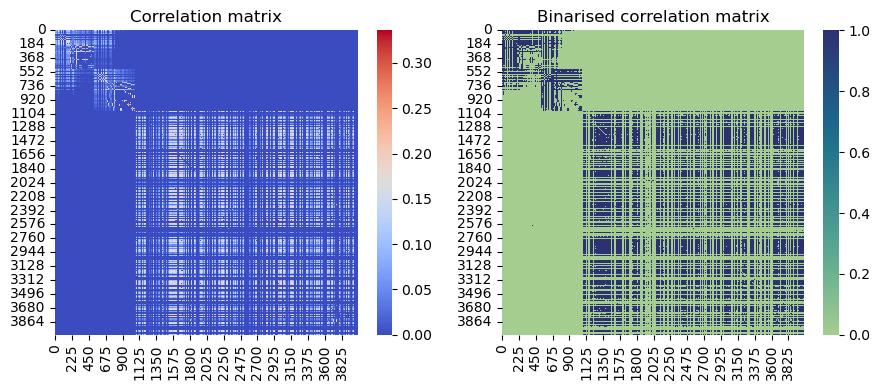

In [13]:
# we can also perform visual checks on the Omega matrix
omega_matrix_bin = np.where(omega_matrix > 0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(omega_matrix, cmap="coolwarm", ax = axes[0])
axes[0].set_title('Correlation matrix', fontsize=12)

sns.heatmap(omega_matrix_bin, cmap="crest", ax = axes[1])
axes[1].set_title('Binarised correlation matrix', fontsize=12)

plt.tight_layout()
plt.show()

#### We can save the significance and correlation matrices


In [14]:
omega_matrix.to_csv(path + "/trifbif/bIFW_omega_matrix_nonans.csv")
chip_masked.to_csv(path + "/trifbif/bIFW_sign_matrix_nonans.csv")
chip.to_csv(path + "/trifbif/bIFW_sign_matrix_raw_nonans.csv")

### Obtain weights and ranks to evaluate performance

In [104]:
# The weight calculation is simply the average of the Omega values weighted by the corresponding Phi value
def weights_IFW(masked_omega, masked_sign_matrix, normalise_by_edges = False):
    w = np.zeros(masked_omega.shape[1])
    for i in range(masked_omega.shape[0]):
        wsum = np.sum(masked_sign_matrix.iloc[i])
        prod = masked_omega.iloc[i].values * masked_sign_matrix.iloc[i].values
        if wsum > 0:
            w[i] = np.nansum(prod) / wsum
        else:
            w[i] = 0
            
    #w = np.average(masked_omega,weights=masked_sign_matrix,axis=0)
    if normalise_by_edges == True:
        edges = (masked_sign_matrix > 0).sum(1)
        n_w = w/edges
        return w, n_w, edges
    else:
        return w

weights, n_weights, _ = weights_IFW(omega_matrix, chip_masked, normalise_by_edges=True)
ranks = np.argsort(-weights)
n_ranks = np.argsort(-n_weights)

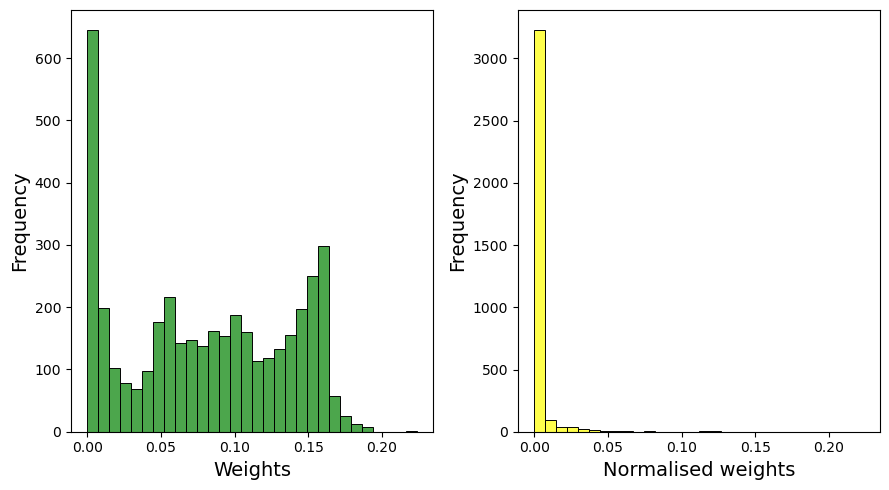

In [16]:
# we can visualise the distribution of weights
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
sns.histplot(weights, bins=30, color='green', alpha=0.7, ax = axes[0])
axes[0].set_xlabel('Weights', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

sns.histplot(n_weights, bins=30, color='yellow', alpha=0.7, ax = axes[1])
axes[1].set_xlabel('Normalised weights', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()


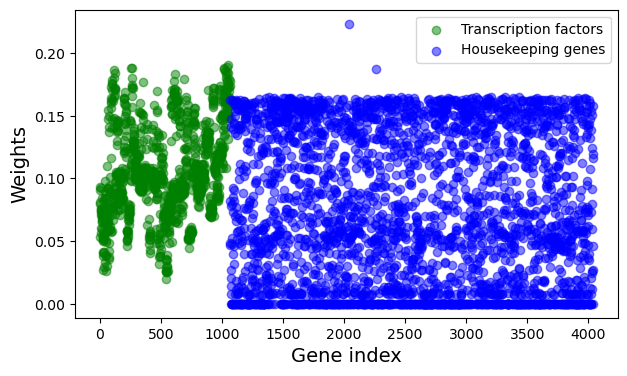

In [35]:
# Plotting weights wrt gene index, assuming synthetic genes are ordered
n = syndata.shape[1]
geneIDs = np.arange(n)
plt.figure(figsize=(7, 4))
plt.scatter(geneIDs[0:1065], weights[0:1065], c='green', label='Transcription factors', alpha=0.5)
plt.scatter(geneIDs[1066:4040], weights[1066:4040], c='blue', label='Housekeeping genes', alpha=0.5)
plt.xlabel('Gene index', fontsize=14)
plt.ylabel('Weights', fontsize=14)
plt.legend()
plt.show()

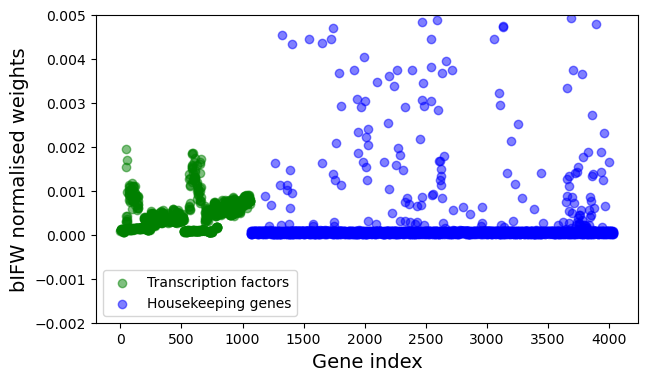

In [96]:
plt.figure(figsize=(7, 4))
plt.scatter(geneIDs[0:1065], n_weights[0:1065], c='green', label='Transcription factors', alpha=0.5)
plt.scatter(geneIDs[1066:4040], n_weights[1066:4040], c='blue', label='Housekeeping genes', alpha=0.5)
plt.xlabel('Gene index', fontsize=14)
plt.ylabel('bIFW normalised weights', fontsize=14)
plt.ylim(-.002,0.005)
plt.legend()
plt.show()

Once weights are obtained, we can assess gene rank performance based on ground truth, while comparing it to Highly Variable Gene selection (HVG) from Scran and Seurat, and cESFW from Radley et al, 2023

In [105]:
# Load cESFW results from Arthur's paper
ESSs = np.load(path + "trifbif/ESSs.npy")
EPs = np.load(path + "trifbif/EPs.npy")

Masked_ESSs = ESSs.copy()
Masked_ESSs[EPs < 0] = 0
Masked_EPs = EPs.copy()
Masked_EPs[EPs < 0] = 0
Usable_Inds = np.where(np.sum(Masked_EPs,axis=0)>0)[0]
Feature_Weights = np.zeros(ESSs.shape[0])
Feature_Weights[Usable_Inds] = np.average(np.absolute(ESSs[np.ix_(Usable_Inds,Usable_Inds)]),weights=Masked_EPs[np.ix_(Usable_Inds,Usable_Inds)],axis=0)
Significant_Genes_Per_Gene = (Masked_EPs > 0).sum(1)
Normalised_Network_Feature_Weights = Feature_Weights/Significant_Genes_Per_Gene
cESFW_Ranked_Genes = np.argsort(-Normalised_Network_Feature_Weights)
nonorm_ranks = np.argsort(-Feature_Weights)

C:\Users\sergi\AppData\Local\Temp\ipykernel_19624\3392567595.py:13: RuntimeWarning: invalid value encountered in divide
  Normalised_Network_Feature_Weights = Feature_Weights/Significant_Genes_Per_Gene


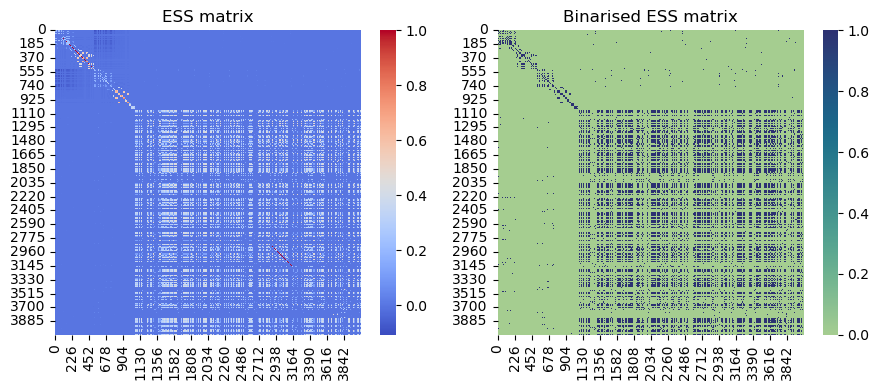

In [61]:
# the ESS matrix
ESS_matrix_bin = np.where(Masked_ESSs > 0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(Masked_ESSs, cmap="coolwarm", ax = axes[0])
axes[0].set_title('ESS matrix', fontsize=12)

sns.heatmap(ESS_matrix_bin, cmap="crest", ax = axes[1])
axes[1].set_title('Binarised ESS matrix', fontsize=12)

plt.tight_layout()
plt.show()

In [106]:
# load files and orders (or ranks)
Structured_Genes = np.where(syndata.columns.str.contains("TF"))[0]
House_Keeping_Genes = np.where(syndata.columns.str.contains("HK"))[0]
SCRAN_HVG_Order = np.asarray(pd.read_csv(path + "trifbif/scran_trifbif_data.csv",header=0,index_col=0)).T[0]
Seurat_HVG_Order = np.asarray(pd.read_csv(path + "trifbif/seurat_trifbif_data.csv",header=0,index_col=0)).T[0]


In [107]:
def drop_zerogenes(zerogenes, rank, weights = False):
    if weights == False:
        indices = np.where(np.isin(rank, zerogenes))[0]
        rank_dropped = np.delete(rank, indices)
        print(f"There are {len(rank_dropped)} genes left after dropping zero genes.")
    if weights == True:
        indices = zerogenes
        rank_dropped = np.delete(rank, indices)
        print(f"There are {len(rank_dropped)} genes left after dropping zero genes.")
    return rank_dropped

In [108]:
House_Keeping_Genes = drop_zerogenes(zerogenes, House_Keeping_Genes)
Structured_Genes = drop_zerogenes(zerogenes, Structured_Genes)
SCRAN_HVG_Order = drop_zerogenes(zerogenes, SCRAN_HVG_Order)
Seurat_HVG_Order = drop_zerogenes(zerogenes, Seurat_HVG_Order)
cESFW_Ranked_Genes = drop_zerogenes(zerogenes, cESFW_Ranked_Genes)

There are 2950 genes left after dropping zero genes.
There are 1065 genes left after dropping zero genes.
There are 4040 genes left after dropping zero genes.
There are 4040 genes left after dropping zero genes.
There are 4040 genes left after dropping zero genes.


In [75]:
# create list of ranks of all comparisons
order_list = [ranks, cESFW_Ranked_Genes, SCRAN_HVG_Order, Seurat_HVG_Order]
order_list_names = ['bIFW', 'cESFW', 'SCRAN', 'Seurat']

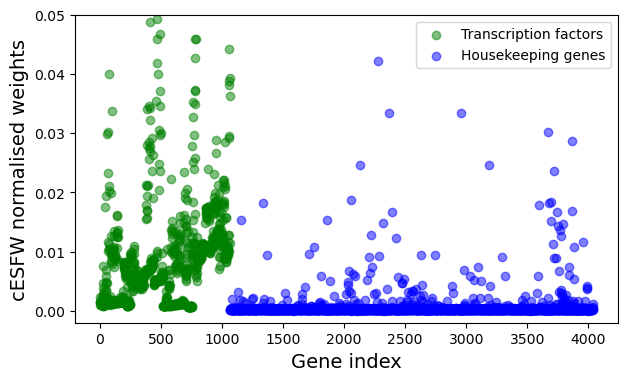

In [109]:
# Plotting cESFW weights wrt gene index, assuming synthetic genes are ordered
plt.figure(figsize=(7, 4))
plt.scatter(geneIDs[0:1065], Normalised_Network_Feature_Weights[0:1065], c='green', label='Transcription factors', alpha=0.5)
plt.scatter(geneIDs[1066:4040], Normalised_Network_Feature_Weights[1066:4040], c='blue', label='Housekeeping genes', alpha=0.5)
plt.xlabel('Gene index', fontsize=14)
plt.ylabel('cESFW normalised weights', fontsize=14)
plt.ylim(-.002,0.05)
plt.legend()
plt.show()

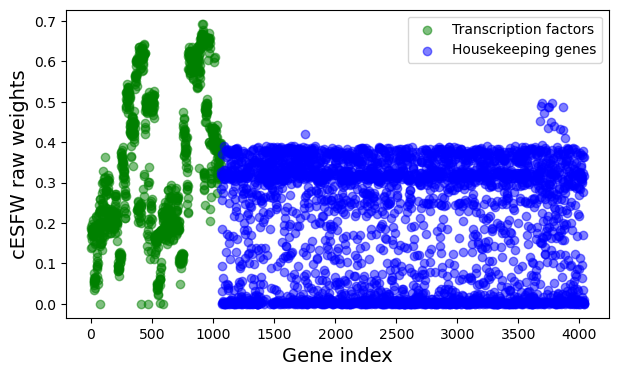

In [110]:
# Plotting cESFW weights wrt gene index, assuming synthetic genes are ordered
plt.figure(figsize=(7, 4))
plt.scatter(geneIDs[0:1065], Feature_Weights[0:1065], c='green', label='Transcription factors', alpha=0.5)
plt.scatter(geneIDs[1066:4040], Feature_Weights[1066:4040], c='blue', label='Housekeeping genes', alpha=0.5)
plt.xlabel('Gene index', fontsize=14)
plt.ylabel('cESFW raw weights', fontsize=14)
plt.legend()
plt.show()

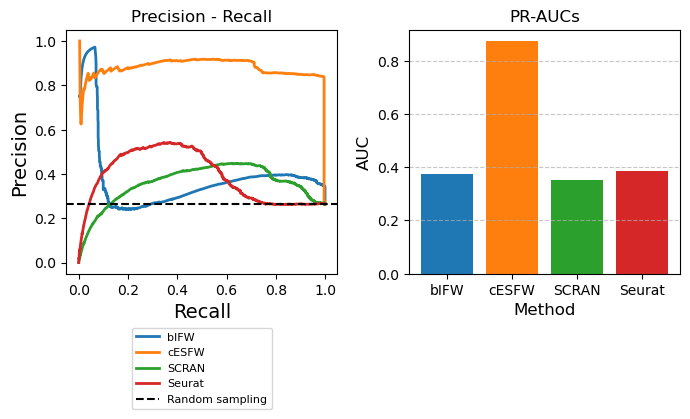

In [77]:
# Precision-Recall curve function
def precision_recall_plot(order_list, order_list_names, structured_genes, housekeeping_genes, spacing=1000, AUC_plot = False):
    n_comparisons = len(order_list)
    Spacing = np.floor(np.linspace(0,order_list[0].shape[0],spacing)).astype("i") #500 points within gene index range
    Spacing = np.delete(Spacing,0)
    def integrate(x, y):
        area = np.trapz(y=y, x=x)
        return area
    # vectors to store values
    Precisions = np.zeros((n_comparisons, Spacing.shape[0]))
    Recalls = np.zeros((n_comparisons, Spacing.shape[0]))
    FPRs = np.zeros((n_comparisons, Spacing.shape[0]))
    for i in np.arange(Spacing.shape[0]):
        for comp in np.arange(n_comparisons):
            top_genes = order_list[comp][np.arange(Spacing[i])]
            captured = np.sum(np.isin(structured_genes, top_genes))
            Precisions[comp, i] = captured / top_genes.shape[0]
            Recalls[comp, i] = captured / structured_genes.shape[0]
            FPs = np.sum(np.isin(housekeeping_genes, top_genes))
            TNs = np.sum(np.isin(housekeeping_genes, top_genes) == 0)
            FPRs[comp, i] = FPs / (FPs + TNs)
    
    if AUC_plot == True:
        PR_AUC_allvalues = []
        fig, axes = plt.subplots(1, 2, figsize=(7, 4.5))
        for comp in np.arange(n_comparisons):
            PR_AUC_allvalues.append(np.round(integrate(Recalls[comp, :], Precisions[comp, :]), 3))
            axes[0].plot(Recalls[comp, :], Precisions[comp, :], label=order_list_names[comp], linewidth=2)
        axes[0].set_title("Precision - Recall", fontsize=12)
        axes[0].axhline((structured_genes.shape[0] / order_list[0].shape[0]), c="black", linestyle="--", label="Random sampling")
        axes[0].set_xlabel("Recall", fontsize=14)
        axes[0].set_ylabel("Precision", fontsize=14)
        axes[0].legend(prop={'size': 8}, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
        
        axes[1].bar(order_list_names, PR_AUC_allvalues, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
        axes[1].set_title("PR-AUCs", fontsize=12)
        axes[1].set_xlabel('Method', fontsize=12)
        axes[1].set_ylabel('AUC', fontsize=12)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    elif AUC_plot == False:
        plt.figure(figsize=(4,4))
        PR_AUC_allvalues = []
        for comp in np.arange(n_comparisons):
            PR_AUC_allvalues.append(np.round(integrate(Recalls[comp, :], Precisions[comp, :]), 3))
            plt.plot(Recalls[comp, :], Precisions[comp, :], label=order_list_names[comp], linewidth=2)
        #plt.title("Precision - Recall", fontsize=12)
        plt.axhline((structured_genes.shape[0] / order_list[0].shape[0]), c="black", linestyle="--", label="Random sampling")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.legend(prop={'size': 8}, loc='center', bbox_to_anchor=(0.5, 0.2), ncol=1)
        plt.tight_layout()
        plt.show()
        
    return PR_AUC_allvalues

AUCs = precision_recall_plot(order_list, order_list_names, structured_genes=Structured_Genes, housekeeping_genes=House_Keeping_Genes, spacing=1000, AUC_plot=True)

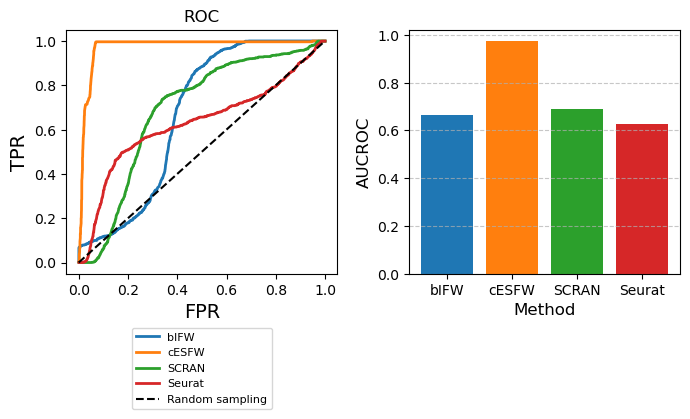

In [78]:
# ROC function
def ROC_plot(order_list, order_list_names, structured_genes, housekeeping_genes, spacing=1000, AUC_plot = False):
    n_comparisons = len(order_list)
    Spacing = np.floor(np.linspace(0,order_list[0].shape[0],spacing)).astype("i") #500 points within gene index range
    Spacing = np.delete(Spacing,0)
    def integrate(x, y):
        area = np.trapz(y=y, x=x)
        return area
    # vectors to store values
    Precisions = np.zeros((n_comparisons, Spacing.shape[0]))
    Recalls = np.zeros((n_comparisons, Spacing.shape[0]))
    FPRs = np.zeros((n_comparisons, Spacing.shape[0]))
    for i in np.arange(Spacing.shape[0]):
        for comp in np.arange(n_comparisons):
            top_genes = order_list[comp][np.arange(Spacing[i])]
            captured = np.sum(np.isin(structured_genes, top_genes))
            Precisions[comp, i] = captured / top_genes.shape[0]
            Recalls[comp, i] = captured / structured_genes.shape[0]
            FPs = np.sum(np.isin(housekeeping_genes, top_genes))
            TNs = np.sum(np.isin(housekeeping_genes, top_genes) == 0)
            FPRs[comp, i] = FPs / (FPs + TNs)
    
    if AUC_plot == True:
        AUCROC_allvalues = []
        fig, axes = plt.subplots(1, 2, figsize=(7, 4.5))
        for comp in np.arange(n_comparisons):
            AUCROC_allvalues.append(np.round(integrate(FPRs[comp, :], Recalls[comp, :]), 3))
            axes[0].plot(FPRs[comp, :], Recalls[comp, :], label=order_list_names[comp], linewidth=2)
        axes[0].plot(np.array([0,1]), c="black", linestyle="--", label="Random sampling")
        axes[0].set_title("ROC", fontsize=12)
        axes[0].set_xlabel("FPR", fontsize=14)
        axes[0].set_ylabel("TPR", fontsize=14)
        axes[0].legend(prop={'size': 8}, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
        
        axes[1].bar(order_list_names, AUCROC_allvalues, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
        #axes[1].set_title("AUCROC", fontsize=12)
        axes[1].set_xlabel('Method', fontsize=12)
        axes[1].set_ylabel('AUCROC', fontsize=12)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    elif AUC_plot == False:
        plt.figure(figsize=(4,4))
        AUCROC_allvalues = []
        for comp in np.arange(n_comparisons):
            AUCROC_allvalues.append(np.round(integrate(FPRs[comp, :], Recalls[comp, :]), 3))
            plt.plot(FPRs[comp, :], Recalls[comp, :], label=order_list_names[comp], linewidth=2)
        #plt.title("ROC", fontsize=12)
        plt.plot(np.array([0,1]), c="black", linestyle="--", label="Random sampling")
        plt.xlabel("FPR", fontsize=14)
        plt.ylabel("TPR", fontsize=14)
        plt.legend(prop={'size': 8}, loc='center', bbox_to_anchor=(0.5, 0.2), ncol=1)
        plt.tight_layout()
        plt.show()
        
    return AUCROC_allvalues

AUCROCs = ROC_plot(order_list, order_list_names, structured_genes=Structured_Genes, housekeeping_genes=House_Keeping_Genes, spacing=1000, AUC_plot=True)

#### what about normalised weights?

In [113]:
nonorm_ranks = drop_zerogenes(zerogenes, nonorm_ranks)

There are 4040 genes left after dropping zero genes.


In [115]:
# create list of ranks of all comparisons
order_list = [ranks, n_ranks, cESFW_Ranked_Genes, nonorm_ranks, SCRAN_HVG_Order, Seurat_HVG_Order]
order_list_names = ['bIFW', 'nw_bIFW', 'nw_cESFW', 'w_cESFW', 'SCRAN', 'Seurat']

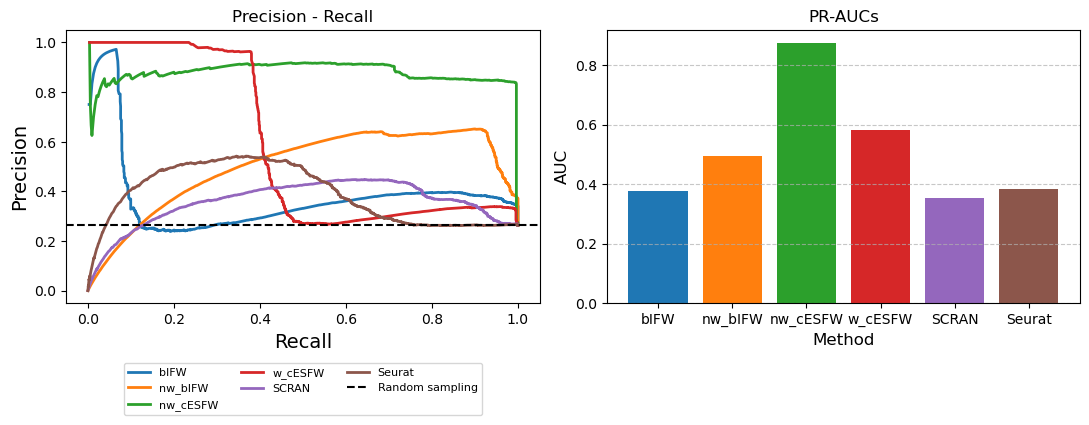

In [116]:
# Precision-Recall curve function
def precision_recall_plot(order_list, order_list_names, structured_genes, housekeeping_genes, spacing=1000, AUC_plot = False):
    n_comparisons = len(order_list)
    Spacing = np.floor(np.linspace(0,order_list[0].shape[0],spacing)).astype("i") #500 points within gene index range
    Spacing = np.delete(Spacing,0)
    def integrate(x, y):
        area = np.trapz(y=y, x=x)
        return area
    # vectors to store values
    Precisions = np.zeros((n_comparisons, Spacing.shape[0]))
    Recalls = np.zeros((n_comparisons, Spacing.shape[0]))
    FPRs = np.zeros((n_comparisons, Spacing.shape[0]))
    for i in np.arange(Spacing.shape[0]):
        for comp in np.arange(n_comparisons):
            top_genes = order_list[comp][np.arange(Spacing[i])]
            captured = np.sum(np.isin(structured_genes, top_genes))
            Precisions[comp, i] = captured / top_genes.shape[0]
            Recalls[comp, i] = captured / structured_genes.shape[0]
            FPs = np.sum(np.isin(housekeeping_genes, top_genes))
            TNs = np.sum(np.isin(housekeeping_genes, top_genes) == 0)
            FPRs[comp, i] = FPs / (FPs + TNs)
    
    if AUC_plot == True:
        PR_AUC_allvalues = []
        fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
        for comp in np.arange(n_comparisons):
            PR_AUC_allvalues.append(np.round(integrate(Recalls[comp, :], Precisions[comp, :]), 3))
            axes[0].plot(Recalls[comp, :], Precisions[comp, :], label=order_list_names[comp], linewidth=2)
        axes[0].set_title("Precision - Recall", fontsize=12)
        axes[0].axhline((structured_genes.shape[0] / order_list[0].shape[0]), c="black", linestyle="--", label="Random sampling")
        axes[0].set_xlabel("Recall", fontsize=14)
        axes[0].set_ylabel("Precision", fontsize=14)
        axes[0].legend(prop={'size': 8}, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
        
        axes[1].bar(order_list_names, PR_AUC_allvalues, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", '#9467bd', '#8c564b'])
        axes[1].set_title("PR-AUCs", fontsize=12)
        axes[1].set_xlabel('Method', fontsize=12)
        axes[1].set_ylabel('AUC', fontsize=12)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    elif AUC_plot == False:
        plt.figure(figsize=(6,4))
        PR_AUC_allvalues = []
        for comp in np.arange(n_comparisons):
            PR_AUC_allvalues.append(np.round(integrate(Recalls[comp, :], Precisions[comp, :]), 3))
            plt.plot(Recalls[comp, :], Precisions[comp, :], label=order_list_names[comp], linewidth=2)
        #plt.title("Precision - Recall", fontsize=12)
        plt.axhline((structured_genes.shape[0] / order_list[0].shape[0]), c="black", linestyle="--", label="Random sampling")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.legend(prop={'size': 8}, loc='center', bbox_to_anchor=(0.5, 0.2), ncol=1)
        plt.tight_layout()
        plt.show()
        
    return PR_AUC_allvalues

AUCs = precision_recall_plot(order_list, order_list_names, structured_genes=Structured_Genes, housekeeping_genes=House_Keeping_Genes, spacing=1000, AUC_plot=True)

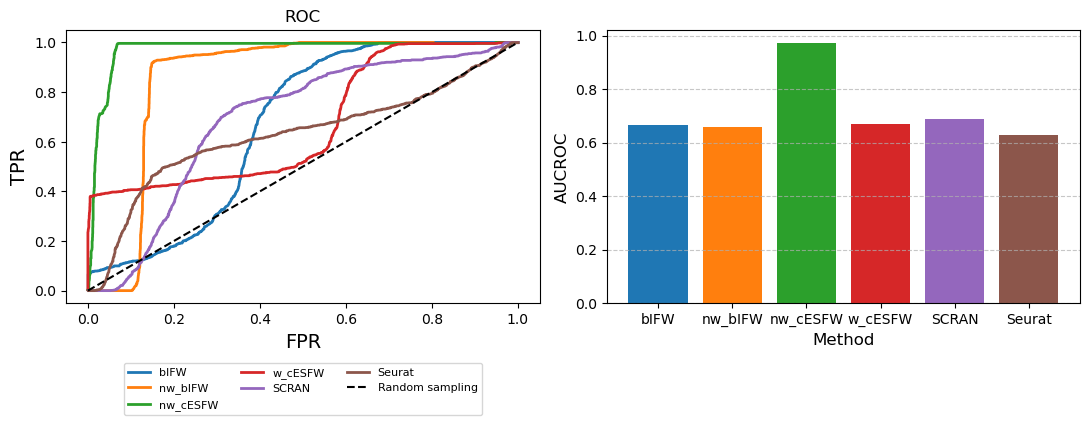

In [117]:
# ROC function
def ROC_plot(order_list, order_list_names, structured_genes, housekeeping_genes, spacing=1000, AUC_plot = False):
    n_comparisons = len(order_list)
    Spacing = np.floor(np.linspace(0,order_list[0].shape[0],spacing)).astype("i") #500 points within gene index range
    Spacing = np.delete(Spacing,0)
    def integrate(x, y):
        area = np.trapz(y=y, x=x)
        return area
    # vectors to store values
    Precisions = np.zeros((n_comparisons, Spacing.shape[0]))
    Recalls = np.zeros((n_comparisons, Spacing.shape[0]))
    FPRs = np.zeros((n_comparisons, Spacing.shape[0]))
    for i in np.arange(Spacing.shape[0]):
        for comp in np.arange(n_comparisons):
            top_genes = order_list[comp][np.arange(Spacing[i])]
            captured = np.sum(np.isin(structured_genes, top_genes))
            Precisions[comp, i] = captured / top_genes.shape[0]
            Recalls[comp, i] = captured / structured_genes.shape[0]
            FPs = np.sum(np.isin(housekeeping_genes, top_genes))
            TNs = np.sum(np.isin(housekeeping_genes, top_genes) == 0)
            FPRs[comp, i] = FPs / (FPs + TNs)
    
    if AUC_plot == True:
        AUCROC_allvalues = []
        fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
        for comp in np.arange(n_comparisons):
            AUCROC_allvalues.append(np.round(integrate(FPRs[comp, :], Recalls[comp, :]), 3))
            axes[0].plot(FPRs[comp, :], Recalls[comp, :], label=order_list_names[comp], linewidth=2)
        axes[0].plot(np.array([0,1]), c="black", linestyle="--", label="Random sampling")
        axes[0].set_title("ROC", fontsize=12)
        axes[0].set_xlabel("FPR", fontsize=14)
        axes[0].set_ylabel("TPR", fontsize=14)
        axes[0].legend(prop={'size': 8}, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
        
        axes[1].bar(order_list_names, AUCROC_allvalues, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", '#9467bd', '#8c564b'])
        #axes[1].set_title("AUCROC", fontsize=12)
        axes[1].set_xlabel('Method', fontsize=12)
        axes[1].set_ylabel('AUCROC', fontsize=12)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    elif AUC_plot == False:
        plt.figure(figsize=(6,4))
        AUCROC_allvalues = []
        for comp in np.arange(n_comparisons):
            AUCROC_allvalues.append(np.round(integrate(FPRs[comp, :], Recalls[comp, :]), 3))
            plt.plot(FPRs[comp, :], Recalls[comp, :], label=order_list_names[comp], linewidth=2)
        #plt.title("ROC", fontsize=12)
        plt.plot(np.array([0,1]), c="black", linestyle="--", label="Random sampling")
        plt.xlabel("FPR", fontsize=14)
        plt.ylabel("TPR", fontsize=14)
        plt.legend(prop={'size': 8}, loc='center', bbox_to_anchor=(0.5, 0.2), ncol=3)
        plt.tight_layout()
        plt.show()
        
    return AUCROC_allvalues

AUCROCs = ROC_plot(order_list, order_list_names, structured_genes=Structured_Genes, housekeeping_genes=House_Keeping_Genes, spacing=1000, AUC_plot=True)